# Table of Contents
 <p>

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from skimage.transform import rescale
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imread

class BeetleDataset:
    
    def __init__(self, raw_files, label_files):
        self.raw_files = raw_files
        self.label_files = label_files
        self.raw_imgs = [imread(f, mode='RGB') for f in self.raw_files]
        self.label_imgs = [imread(f, mode='RGB') for f in self.label_files]
    
    def generate_batch(self, n=100):
        """
        Generates a tensor of images with n randomly places squares. Images are of size 240x240.
        Randomly select a file
        Extract a random patch
        DO this until batch generation is complete
        
            n (int): Batch size
        
        Returns:
            imgs (n, 3, 320, 320): RGB image tensor
            labels (n, v(n), 4): Numpy array with variable no of boxes per image
        """
        images = []
        labels = []
        
        n_count = 0

        while n_count<n:
            idx = np.random.choice(np.arange(len(self.raw_imgs)))
            
            raw_img = self.raw_imgs[idx]
            label_img = self.label_imgs[idx]
        
            patch, patch_bw = self.get_random_patch(raw_img, label_img)
            boxes = self.generate_boxes(patch_bw)
            
            # At least one label in the box
            if len(boxes):
                images.append(patch)
                labels.append(boxes)
                n_count += 1

        return np.array(images), np.array(labels)
        
    def get_random_patch(self, raw_img, label_img, size=160):
        # Sample centre
        cx = np.random.randint(0+size/2, raw_img.shape[1]-size/2)
        cy = np.random.randint(0+size/2, raw_img.shape[0]-size/2)
        
        # Extract and rescale patch
        patch_raw = raw_img[cy-size/2:cy+size/2,cx-size/2:cx+size/2]
        patch_label = label_img[cy-size/2:cy+size/2,cx-size/2:cx+size/2]
        
        # Upsample both raw and label patch
        patch_resized_raw = rescale(patch_raw, 2)
        patch_resized_label = rescale(patch_label, 2)
        patch_resized_bw = np.zeros((patch_resized_label.shape[0], patch_resized_label.shape[1]))
        
        # Extract the ellipse region separately
        indices = np.where(patch_resized_label==[0,0,255])
        patch_resized_bw[indices[0],indices[1]]=1

        return patch_resized_raw, patch_resized_bw
    
    def visualize_batch(self, x, y):
        # Allows one to visualize a batch for visual verification
        # Run training first, then run visual verification for initiation
        
        for x_img, y_boxes in zip(x, y):
            fig = plt.figure(figsize=(10,10))
            # Show the img
            
            for y_box in y_boxes:
                cv2.line(x_img,(y_box[0], y_box[1]),(y_box[2], y_box[3]),(255,0,0),3)
            
            plt.imshow(x_img)
            fig.text(0.5, 0.05, str(x_img.shape), ha='center')

            plt.show()
    
    def generate_boxes(self, patch):
        # Find all contours
        contours, hierarchy = cv2.findContours(patch.astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        boxes = []

        for cnt in contours:
            # Find rotated box
            rect = cv2.minAreaRect(cnt)

            box = cv2.cv.BoxPoints(rect)
            box = np.int0(box)

            # Find left most and right most point
            p_left = box[box[:,0].argmin(),:]
            p_right = box[box[:,0].argmax(),:]

            # Add if condition to check that area of box is fine
            box_final = np.hstack([p_left, p_right])
            boxes.append(box_final)
            #cv2.drawContours(patch_resized, [box], -1, (255,0,0),2)
            #cv2.line(patch_resized,(box_final[0], box_final[1]),(box_final[2], box_final[3]),(255,0,0),3)

        return np.array(boxes)

In [9]:
!git commit -am "adding all files before making big changes"

[pawan_files d7e5735] adding all files before making big changes
 15 files changed, 1975 insertions(+), 568 deletions(-)
 create mode 100644 PatchGenerationMinimalWorkingExample.ipynb
 rewrite RotationEllipseDetection.ipynb (73%)
 create mode 100644 TrainingRotation-Pfunctions-multi-square.ipynb
 create mode 100644 class_lab_densebox_1
 create mode 100644 class_lab_densebox_2
 create mode 100644 class_lab_densebox_3
 create mode 100644 class_lab_densebox_4
 create mode 100644 class_lab_densebox_5
 create mode 100644 raw_densebox_1
 create mode 100644 raw_densebox_2
 create mode 100644 raw_densebox_3
 create mode 100644 raw_densebox_4
 create mode 100644 raw_densebox_5


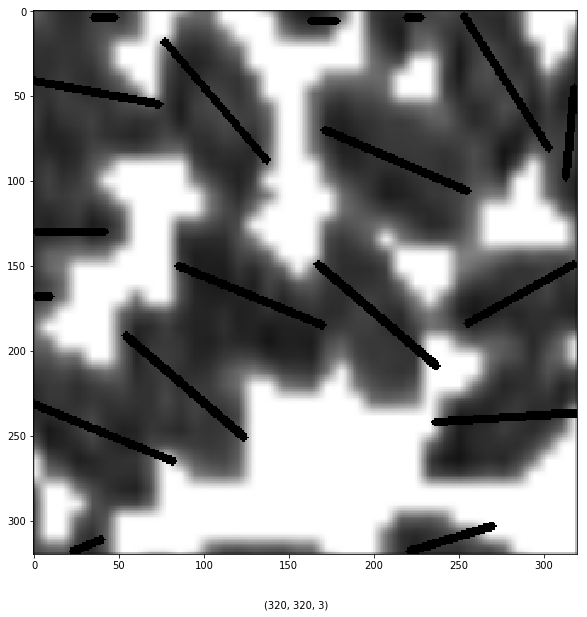

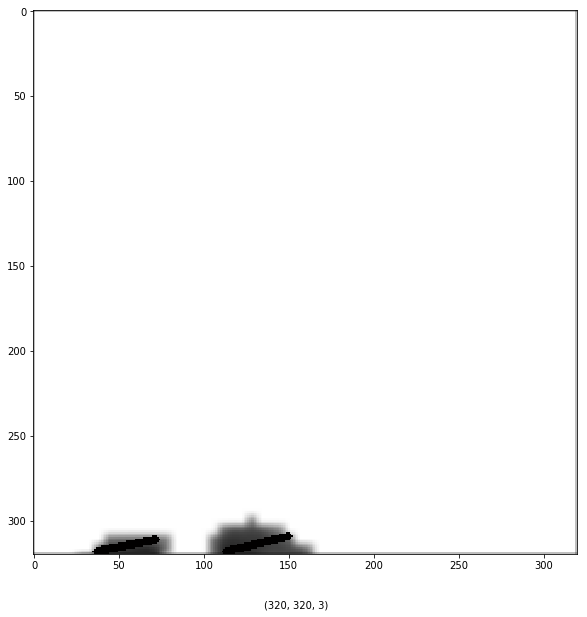

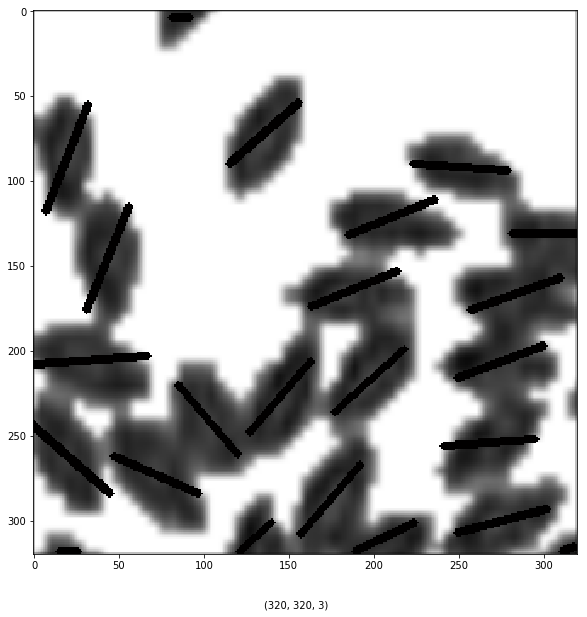

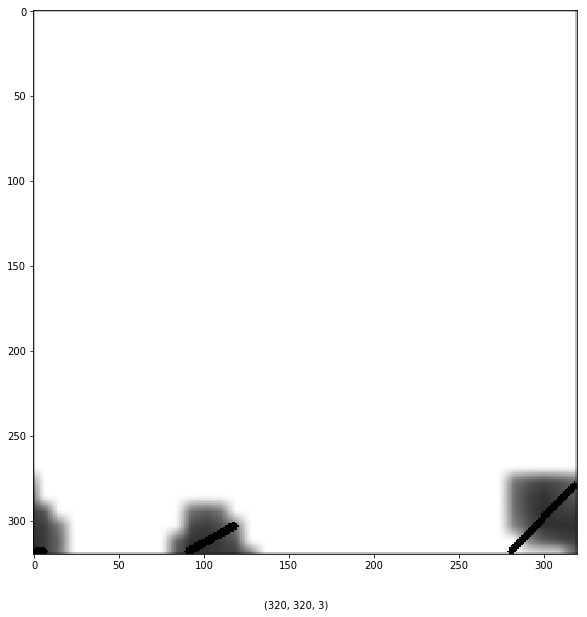

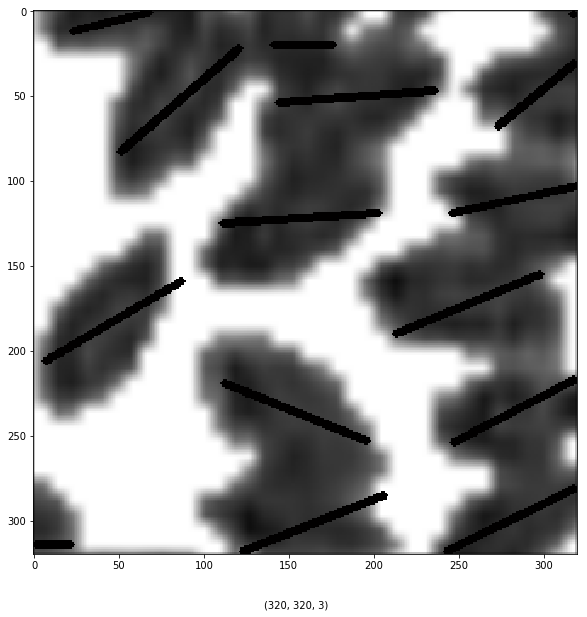

In [10]:
raw_files = ['raw_densebox_1', 'raw_densebox_2', 'raw_densebox_3', 'raw_densebox_4', 'raw_densebox_5']
label_files = ['class_lab_densebox_1', 'class_lab_densebox_2', 'class_lab_densebox_3', 'class_lab_densebox_4', 'class_lab_densebox_5']
db = BeetleDataset(raw_files, label_files)

x_b,y_b=db.generate_batch(n=5)
db.visualize_batch(x_b,y_b)
# Why is the magnification non uniform? Huh Huh HUH?